# setup

In [8]:
import cm1_load_utils as cl
import load_ppe_fun as lp
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import itertools

In [2]:
nikki = '2025-08-28'
target_nikki = 'target'
sim_config = 'NCE_nopredNc_nopredss'
target_sim_config = 'NCE'

plot_dir = f"plots/{nikki}/{sim_config}/"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

n_init = 1
target_mp = 'BIN-TAU'
train_mp = 'SLC-BOSS'
mconfigs = os.listdir(cl.output_dir + nikki)
vars_strs, vars_vn = lp.get_dics(cl.output_dir, target_nikki, target_sim_config, n_init)
var_interest = []
var_interest += ['M0_dmprof', 'M3_dmprof', 'M4_dmprof', 'M6_dmprof'] # domain-mean profiles
var_interest += ['M0_dmpath', 'M3_dmpath', 'M4_dmpath', 'M6_dmpath'] # domain-mean path
var_interest += ['M0_curtain_mean', 'M3_curtain_mean', 'M4_curtain_mean', 'M6_curtain_mean'] # curtain
# var_interest += ['w', 'w_dmprof', 'w_curtain_slice', 'w_curtain_mean'] # 4D var
var_interest += ['u_dmprof', 'v_dmprof', 'w_dmprof']
# var_interest += ['M0', 'M3']

file_info = {'dir': cl.output_dir, 
             'date': nikki,
             'vars_vn': vars_vn}

if 'nc_dict' not in globals():
    nc_dict = {}

In [21]:
import importlib
importlib.reload(cl)

<module 'cm1_load_utils' from '/home/arthurhu/BOSS_PPE/cm1_load_utils.py'>

In [3]:
# load BIN data

for initcond_combo in itertools.product(*[vars_strs[0][:1]]):
    ic_str = "".join(initcond_combo)
    file_info.update({'sim_config': target_sim_config,
                      'vars_str': list(initcond_combo),
                      'date': target_nikki,
                      'mp_config': target_mp})
    cl.load_cm1(file_info, var_interest, nc_dict, False)

Loading na20 BIN-TAU variables...: 100%|██████████| 15/15 [00:53<00:00,  3.58s/it]


In [4]:
# load BOSS data

for initcond_combo in itertools.product(*[vars_strs[0][:1]]):
    ic_str = "".join(initcond_combo)
    file_info.update({'sim_config': sim_config,
                      'vars_str': list(initcond_combo),
                      'date': nikki,
                      'mp_config': train_mp})
    cl.load_cm1(file_info, var_interest, nc_dict, False)

Loading na20 SLC-BOSS variables...: 100%|██████████| 15/15 [00:34<00:00,  2.32s/it]


In [5]:
time = nc_dict['time']/3600
mps = ['BIN-TAU', 'SLC-BOSS']
x = nc_dict['x']
z = nc_dict['z']*1e3
icase = 'na20'
plt.rc('font', size=18)

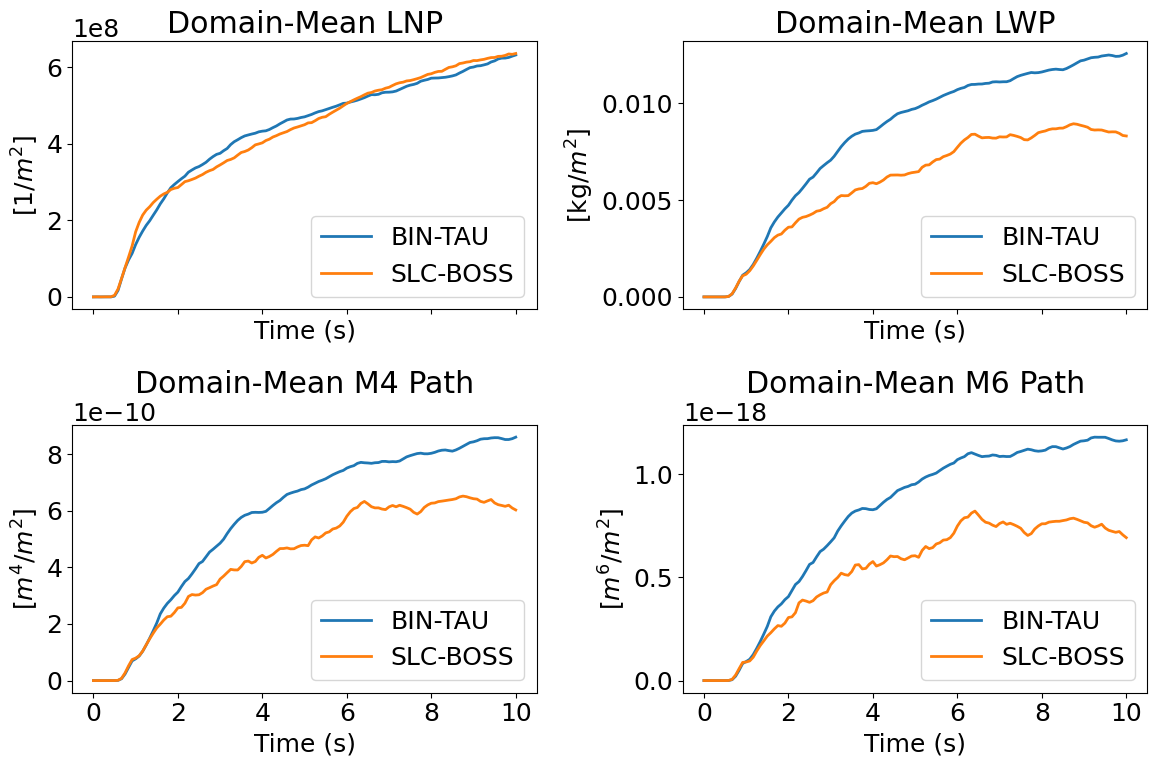

In [6]:
varsplot = ['M0_dmpath', 'M3_dmpath', 'M4_dmpath', 'M6_dmpath']
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axs = axs.flatten()
for i, var in enumerate(varsplot):
    units = cl.output_var_set[var]['var_unit']
    longname = cl.output_var_set[var]['longname']
    for mp in mps:
        axs[i].plot(time, nc_dict['na20'][mp][var]['value'], label=mp, linewidth=2)
    # axs[i].set_yscale('log')
    axs[i].set_title(longname)
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel(f"[{units}]")
    axs[i].legend(loc='lower right')
plt.tight_layout()
plt.savefig(f"{plot_dir}{sim_config}_dm_path.png")


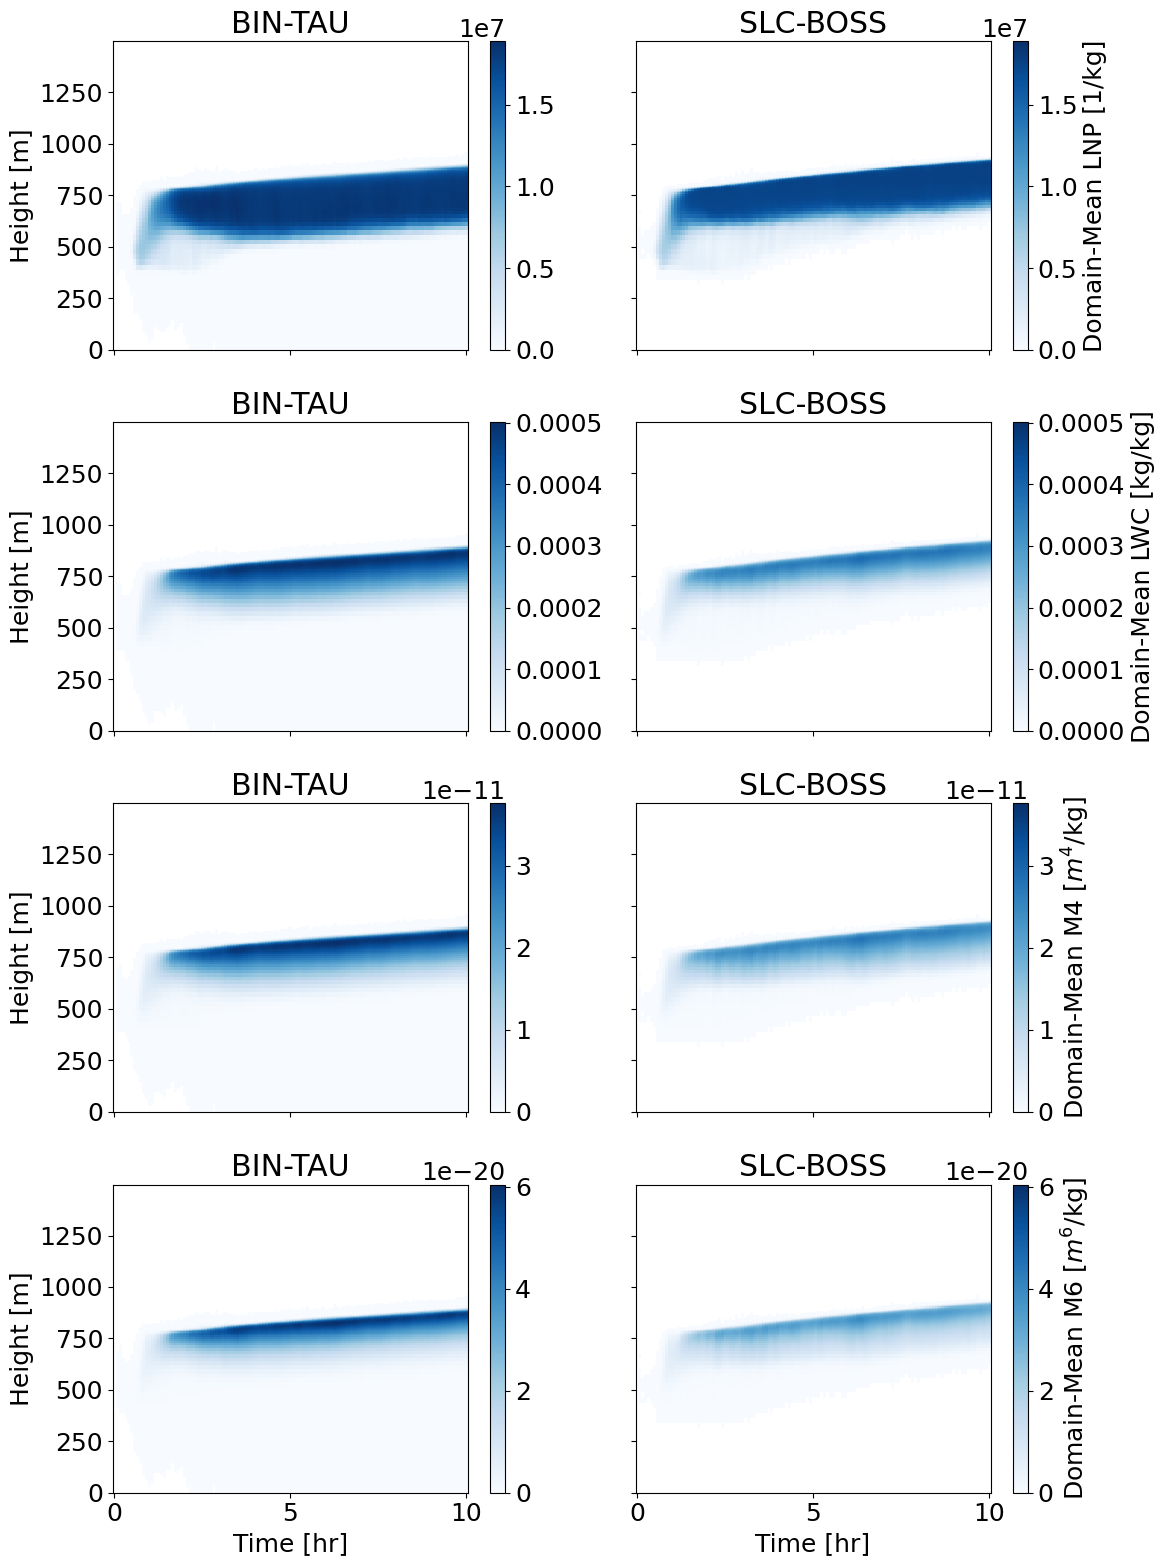

In [7]:
varsplot = ['M0_dmprof', 'M3_dmprof', 'M4_dmprof', 'M6_dmprof']


fig, axs = plt.subplots(len(varsplot), len(mps), figsize=(12, 16), sharex=True, sharey=True)
for i, var in enumerate(varsplot):
    units = cl.output_var_set[var]['var_unit']
    longname = cl.output_var_set[var]['longname']
    for j, mp in enumerate(mps):
        data = nc_dict[icase][mp][var]['value'].T.copy()
        # Ensure SLC-BOSS uses BIN-TAU's colorbar limits and set colorbar to log scale
        if mp == 'SLC-BOSS':
            # Find the corresponding BIN-TAU data for colorbar normalization
            bin_data = nc_dict[icase]['BIN-TAU'][var]['value'].T
            vmin = np.percentile(bin_data[bin_data > 0], 1)
            vmax = np.nanmax(bin_data)
            # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
        else:
            # For BIN-TAU, also use log scale
            data_pos = data[data > 0]
            if data_pos.size > 0:
                vmin = np.percentile(data_pos, 1)
                vmax = np.nanmax(data)
                # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
        data[data <= vmin] = np.nan
        im = axs[i, j].pcolormesh(time, z, data, vmin=vmin, vmax=vmax, cmap='Blues')
        plt.colorbar(im, ax=axs[i, j])
        # INSERT_YOUR_CODE
        axs[i, j].set_title(mp)
        if mp == 'SLC-BOSS':
            im.colorbar.set_label(f"{longname} [{units}]")
        else:
            axs[i, j].set_ylabel('Height [m]')
        if i == len(varsplot) - 1:
            axs[i, j].set_xlabel('Time [hr]')
plt.tight_layout()
# plt.savefig(f"{sim_config}_dm_prof.pdf")
plt.savefig(f"{plot_dir}{sim_config}_dm_prof.png")

In [15]:
vmin, vmax

(np.float32(0.0), np.float32(13256604.0))

<Figure size 640x480 with 0 Axes>

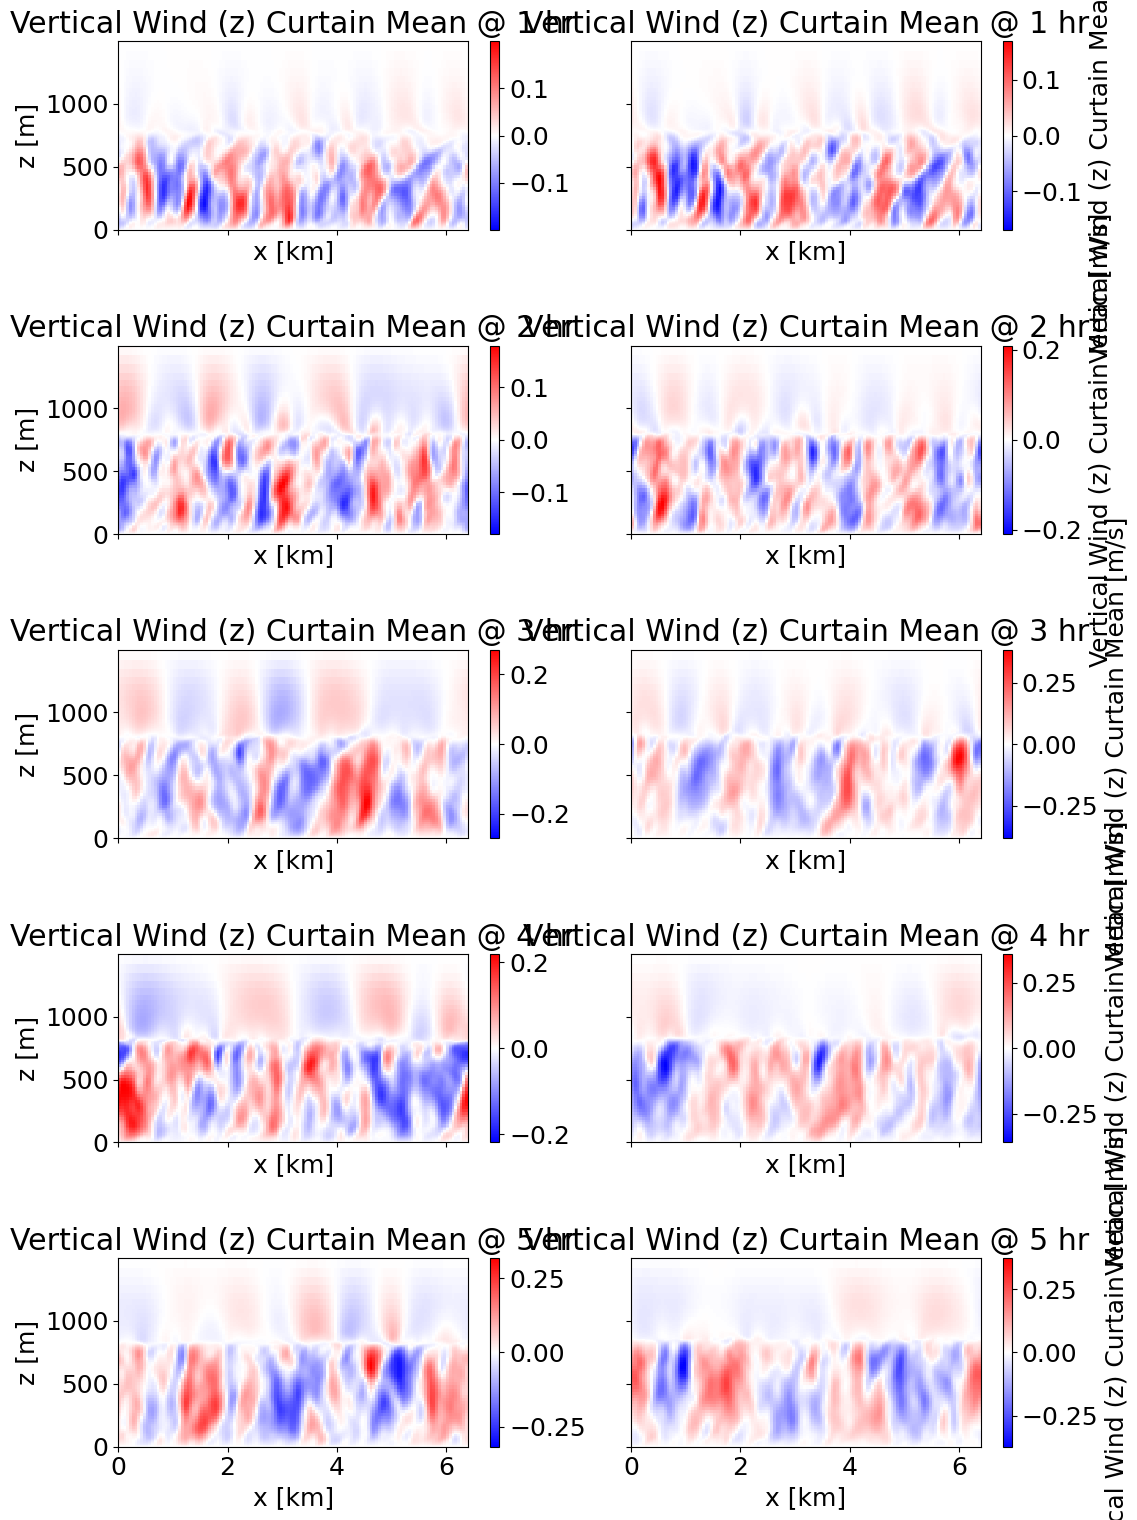

In [43]:
# varsplot = ['M0_curtain_mean', 'M3_curtain_mean', 'M4_curtain_mean', 'M6_curtain_mean']
varsplot = ['w_curtain_mean']
x = nc_dict['x']
z = nc_dict['z']*1e3
time = nc_dict['time']/3600
it_snaps = np.arange(12, len(time), 12)
# it_snaps = [53,54,55]

for var in varsplot:
    plt.figure()
    units = cl.output_var_set[var]['var_unit']
    longname = cl.output_var_set[var]['longname']
    fig, axs = plt.subplots(len(it_snaps), len(mps), figsize=(12, 16), sharex=True, sharey=True)
    for i, it in enumerate(it_snaps):
        for j, mp in enumerate(mps):
            data = nc_dict[icase][mp][var]['value'][it, :, :].copy()
            if mp == 'SLC-BOSS':
                # Find the corresponding BIN-TAU data for colorbar normalization
                bin_data = nc_dict[icase]['BIN-TAU'][var]['value'][it, :, :]
                if var != 'w_curtain_mean':
                    bin_data = bin_data[bin_data > 0]
                    vmin = np.percentile(bin_data, 1)
                else:
                    vmin = np.percentile(bin_data, 0)
                vmax = np.max(bin_data)
                # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
            else:
                # For BIN-TAU, also use log scale
                if var != 'w_curtain_mean':
                    data_pos = data[data > 0]
                    vmin = np.percentile(data_pos, 1)
                else:
                    vmin = np.percentile(data_pos, 0)
                vmax = np.max(data_pos)
                # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
            if var == 'w_curtain_mean':
                im = axs[i, j].pcolormesh(x, z, data, cmap='bwr')
                val_extremes = np.nanmax(np.abs(data))
                im.set_clim(-val_extremes, val_extremes)
            else:
                data[data <= vmin] = np.nan
                im = axs[i, j].pcolormesh(x, z, data, vmin=vmin, vmax=vmax, cmap='Blues')
            axs[i, j].set_title(f'{longname} @ {time[it]:.0f} hr')
            axs[i, j].set_xlabel('x [km]')
            plt.colorbar(im, ax=axs[i, j])
            if mp == 'SLC-BOSS':
                im.colorbar.set_label(f"{longname} [{units}]")
            if mp == 'BIN-TAU':
                axs[i, j].set_ylabel('z [m]')
    plt.tight_layout(pad=2.0)
    # plt.savefig(f"{sim_config}_mean_Y_{var}.pdf")
    plt.savefig(f"{plot_dir}{sim_config}_{var}.png")

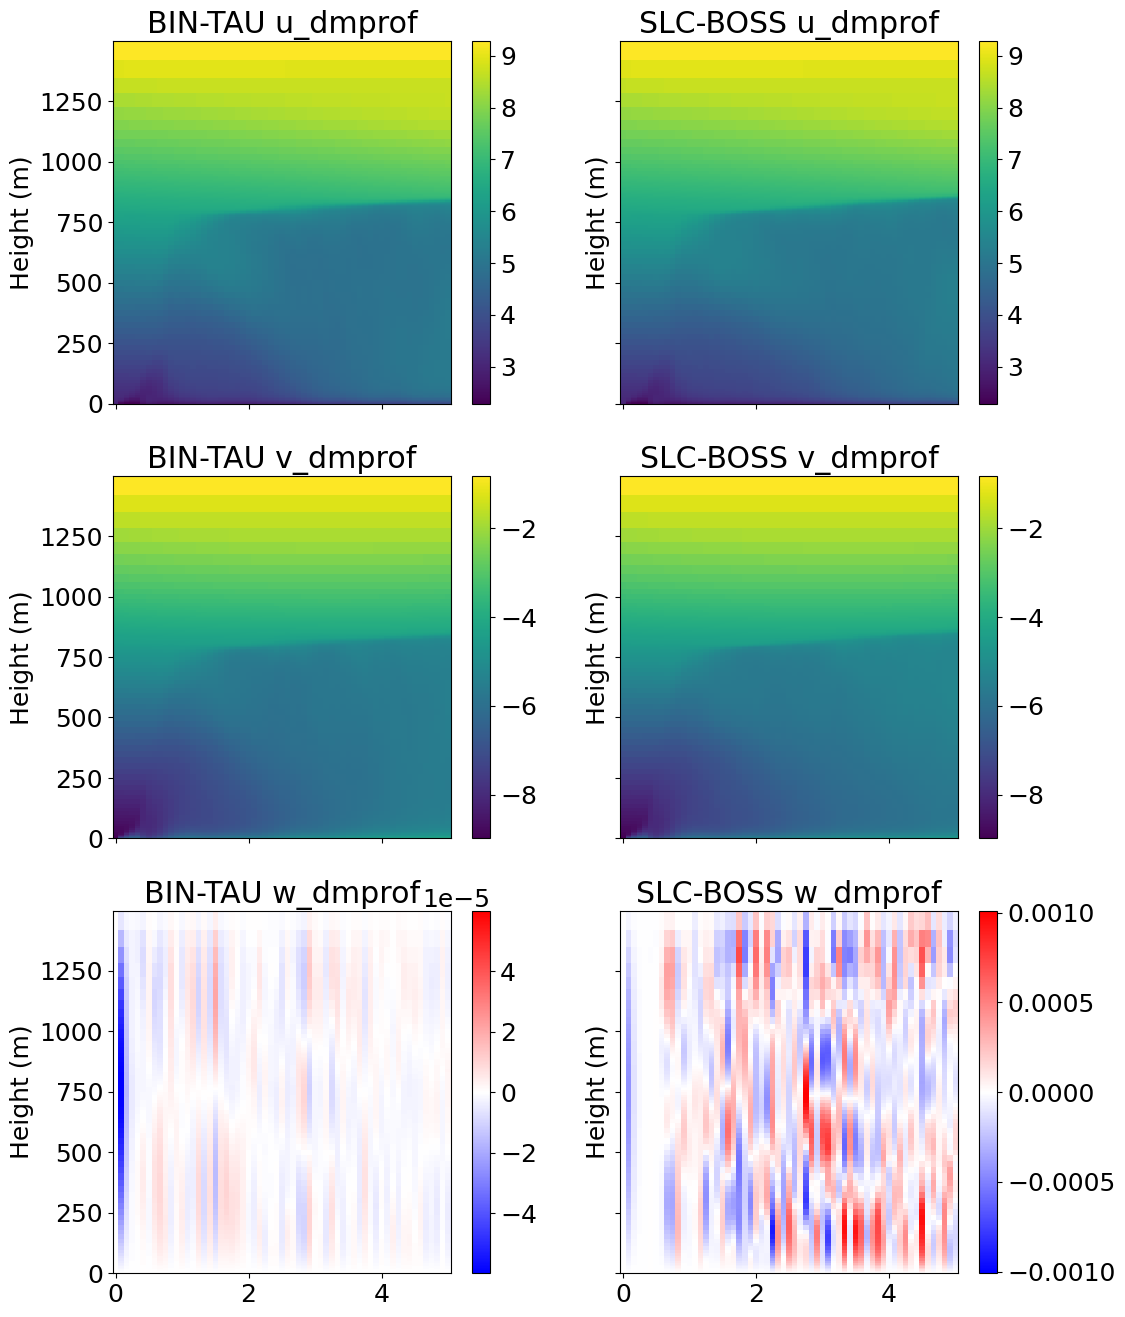

In [20]:
varsplot = ['u_dmprof', 'v_dmprof', 'w_dmprof']
colormaps = ['viridis', 'viridis', 'bwr']
mps = ['BIN-TAU', 'SLC-BOSS']
icase = 'na20'
time = nc_dict['time']/3600
z = nc_dict['z']*1e3

fig, axs = plt.subplots(len(varsplot), len(mps), figsize=(12, 16), sharex=True, sharey=True)
for i, var in enumerate(varsplot):
    for j, mp in enumerate(mps):
        data = nc_dict[icase][mp][var]['value'].T
        if mp == 'SLC-BOSS':
            # Find the corresponding BIN-TAU data for colorbar normalization
            bin_data = nc_dict[icase]['BIN-TAU'][var]['value']
            vmin = np.percentile(bin_data, 0)
            vmax = np.max(bin_data)
            # val_extremes = np.max(np.abs(bin_data))
            val_extremes = np.max(np.abs(data))
            # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
        else:
            # For BIN-TAU, also use log scale
            # data_pos = data[data > 0]
            vmin = np.percentile(data, 0)
            vmax = np.max(data)
            val_extremes = np.max(np.abs(data))
            # im.set_norm(LogNorm(vmin=vmin, vmax=vmax))
        im = axs[i, j].pcolormesh(time, z, data, cmap=colormaps[i])
        if i == 2:
            im.set_clim(-val_extremes, val_extremes)
        plt.colorbar(im, ax=axs[i, j])
        axs[i, j].set_title(f"{mp} {var}")
        axs[i, j].set_ylabel('Height (m)')

plt.savefig(f"{plot_dir}{sim_config}_3D_wind_prof.png")

/tmp/ipykernel_1140374/1713663416.py:1: RuntimeWarning: invalid value encountered in divide
  varplot = nc_dict['na20']['BIN_TAU']['M3_dmprof']['value'].T/nc_dict['na20']['BIN_TAU']['M0_dmprof']['value'].T


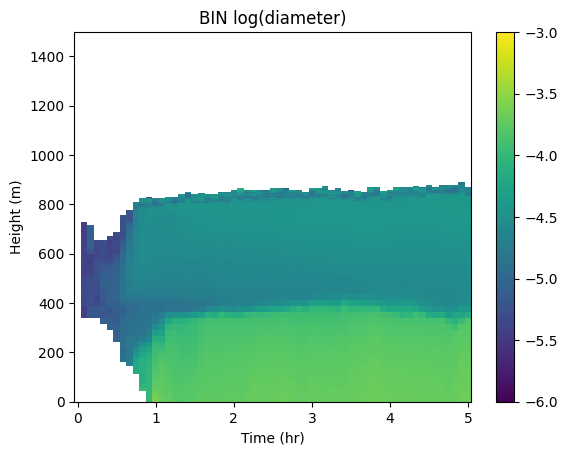

In [ ]:
varplot = nc_dict['na20']['BIN-TAU']['M3_dmprof']['value'].T/nc_dict['na20']['BIN-TAU']['M0_dmprof']['value'].T
plt.pcolormesh(time, z, np.log10(varplot**(1/3)))
plt.colorbar()
plt.clim(-6,-3)
plt.xlabel('Time (hr)')
plt.ylabel('Height (m)')
plt.title('BIN log(diameter)')
plt.show()

/tmp/ipykernel_1140374/2320377537.py:1: RuntimeWarning: invalid value encountered in divide
  varplot = nc_dict['na20']['SLC-BOSS']['M3_dmprof']['value'].T/nc_dict['na20']['SLC-BOSS']['M0_dmprof']['value'].T


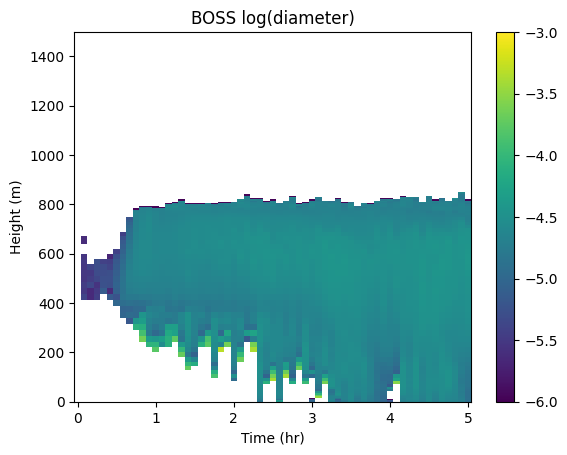

In [33]:
varplot = nc_dict['na20']['SLC-BOSS']['M3_dmprof']['value'].T/nc_dict['na20']['SLC-BOSS']['M0_dmprof']['value'].T
plt.pcolormesh(time, z, np.log10(varplot**(1/3)))
plt.colorbar()
plt.clim(-6,-3)
plt.xlabel('Time (hr)')
plt.ylabel('Height (m)')
plt.title('BOSS log(diameter)')
plt.show()

/tmp/ipykernel_1140374/3741943937.py:2: RuntimeWarning: invalid value encountered in divide
  m3_ratio = nc_dict['na20']['SLC-BOSS']['M6_dmprof']['value'] / nc_dict['na20']['BIN_TAU']['M6_dmprof']['value']


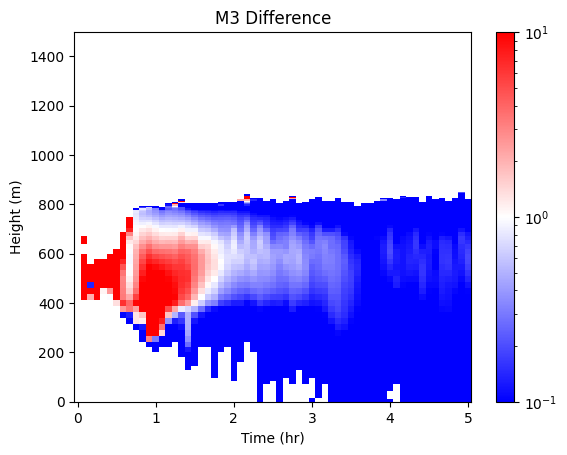

In [ ]:
# m3_diff = nc_dict['na20']['BIN-TAU']['M0_dmprof']['value'] - nc_dict['na20']['SLC-BOSS']['M0_dmprof']['value']
m3_ratio = nc_dict['na20']['SLC-BOSS']['M6_dmprof']['value'] / nc_dict['na20']['BIN-TAU']['M6_dmprof']['value']
plt.pcolormesh(time, z, m3_ratio.T, cmap='bwr', norm=LogNorm())
# val_extremes = np.max(np.abs(m3_ratio))
plt.clim(0.1, 10)
plt.colorbar()
plt.xlabel('Time (hr)')
plt.ylabel('Height (m)')
plt.title('M3 Difference')
plt.show()